In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset,DataLoader
import torchvision.models as models
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.preprocessing import MinMaxScaler

c:\Users\creep\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = "cuda" if torch.cuda.is_available() else 'cpu'
savedModelName = 'phishing_v1.pt'
batch = 32
learning_rate = 0.001

Usage of dataset from https://data.mendeley.com/datasets/c2gw7fy2j4/3
For citation use: Hannousse, Abdelhakim; Yahiouche, Salima (2021), “Web page phishing detection”, Mendeley Data, V3, doi: 10.17632/c2gw7fy2j4.3

In [3]:
# Load the dataset into a pandas dataframe
filename = "datasets/Web_page_Phishing_Detection_Dataset/dataset_phishing.csv"
# Read the file and drop the link itself as the classification will base on features not the link itself
df = pd.read_csv(filename).drop("url", axis="columns").drop("random_domain", axis="columns")
# Print resulting dataframe columns
df.head(1)

,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_or,nb_eq,...,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank,status
0,37,19,0,3,0,0,0,0,0,0,...,0,1,0,45,-1,0,1,1,4,legitimate


In [4]:
# Check what are the labels in the dataset
print("Dataset labels:")
labels = np.unique(df["status"])
print(labels)

# Create map that will allow for encoding of labels in order to be able to be used in PyTorch DataLoader
class_to_idx = {}
for i, status in enumerate(labels):
    class_to_idx[status] = i
print(class_to_idx)

Dataset labels:
['legitimate' 'phishing']
{'legitimate': 0, 'phishing': 1}


In [5]:
# Encode labels using previously created map for labels
df["status"] = df["status"].map(class_to_idx)

# Separate features with classes that they belong to
features = df.iloc[:, :-1]
is_phishing = df.iloc[:,-1:]

# Check if the labels were encoded to 0 and 1
is_phishing.head(5)

,status
0,0
1,1
2,1
3,0
4,0


In [6]:
# Split train data with test data that will allow for checking if the algorithm works fine on new records
train_x, test_x, train_y, test_y = train_test_split(features, is_phishing, 
test_size=0.2, random_state=13, shuffle=True, stratify=is_phishing)

# Create tensors that will be used to create PyTorch Dataset, 
# add float conversion to avoid input type (double) and bias type (float) as they should be the same
# add unsqueze to prevent error of comparing sizes [32, 1] and [32] while learning and validating
train_x_t=torch.from_numpy(train_x.values).float()
train_y_t=torch.from_numpy(train_y['status'].values).float().unsqueeze(1)

test_x_t=torch.from_numpy(test_x.values).float()
test_y_t=torch.from_numpy(test_y['status'].values).float().unsqueeze(1)

# Create datasets necessary for training and validation
trainingSet=TensorDataset(train_x_t,train_y_t)
testingSet=TensorDataset(test_x_t,test_y_t)

# Load data into DataLoader with batch
trainLoader = DataLoader(trainingSet, batch_size=batch, shuffle=True)
testLoader = DataLoader(testingSet, batch_size=batch, shuffle=True)

In [7]:
# Create neural network model to be learned
model = nn.Sequential(
    nn.BatchNorm1d(num_features=86),
    # 87 features in dataset
    nn.Linear(in_features=86,out_features=300),
    nn.ReLU(),
    
    # nn.Conv1d(in_channels=32, out_channels=1, kernel_size=300, stride=1, padding=0, dilation=1),
    # nn.ReLU(),
    # nn.Flatten(),
    # nn.Dropout(p=0.5),
    # nn.LSTMCell(300, 300),

    nn.Linear(in_features=300,out_features=300),
    nn.ReLU(),
    
    nn.Linear(in_features=300,out_features=1),
    nn.Sigmoid()
)

# Cross entropy loss for binary classification
# criterion=nn.BCELoss()

# Combination of the sigmoid activation function and the binary cross-entropy loss
criterion = nn.BCEWithLogitsLoss()

# Tried optimizers
# optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [8]:
noEpochs = 100
epochsRun = 0
loss_vals = []
accs_vals = []
# Train the network
for epoch in range(noEpochs):
    epoch_loss= []

    for i, data in enumerate(trainLoader, 0):
        inputs, labels = data
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss.append(loss.item())

    # Validate the network after each epoch
    with torch.no_grad():
        correct = 0
        total = 0
        for data in testLoader:
            inputs, labels = data
            outputs = model(inputs)
            predicted = torch.round(outputs.data)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epochsRun = epoch + 1
    val_loss = sum(epoch_loss)/len(epoch_loss)
    val_acc = 100 * correct / total

    if epoch > 0 and accs_vals[-1] > val_acc:
        break
    else:
        print('Epoch %d loss: %.3f' % (epoch + 1, val_loss))
        print('Accuracy on the test set: %.2f %%' % (val_acc))
        
        loss_vals.append(val_loss)
        accs_vals.append(val_acc)

torch.save(model, savedModelName)
print('Finished Training')

Epoch 1 loss: 0.545
Accuracy on the test set: 93.53 %
Epoch 2 loss: 0.529
Accuracy on the test set: 94.36 %
Epoch 3 loss: 0.529
Accuracy on the test set: 94.44 %
Finished Training


Final accuracy on the test set: 94.44 %


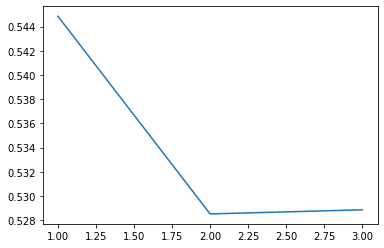

In [9]:
plt.plot(np.linspace(1, epochsRun-1, epochsRun-1).astype(int), loss_vals)
print('Final accuracy on the test set: %.2f %%' % (accs_vals[-1]))